# Sequential rumour stance prediction

Rumours tend to change over time; people focus on different aspects of a story.<br>
We could view this process as distributions in word or sentence embedding space that evolve over time. However, the evolution is erratic in that it is relatively constant for short periods (within rumours) and can be volatile for longer periods (between rumours).

Here we will tackle this problem using a semi-supervised variant of a [Subspace Aligned Classifier](https://www.cv-foundation.org/openaccess/content_iccv_2013/papers/Fernando_Unsupervised_Visual_Domain_2013_ICCV_paper.pdf).

In this experiment, we arrange the rumours in time and align all previous rumours to the current rumour. In this way, we build up a large data set of class-aligned embedding distributions.



In [1]:
!pip install sklearn imblearn scipy pandas

In [0]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import pickle as pc
import dateutil
import numpy.random as rnd

from scipy.linalg import eig, eigh, svd
from scipy.spatial.distance import pdist, cdist, squareform

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline
from collections import Counter

from IPython.core.debugger import Tracer

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set font size
fS = 20

In [0]:
def is_pos_def(A):
    """Check for positive definiteness."""
    return np.all(np.real(np.linalg.eigvals(A)) > 0)

def reg_cov(X):
    """
    Regularize covariance matrix until non-singular.

    Parameters
    ----------
    C : array
        square symmetric covariance matrix.

    Returns
    -------
    C : array
        regularized covariance matrix.

    """
    # Number of data points
    N = X.shape[0]

    # Compute mean of data
    muX = np.mean(X, axis=0, keepdims=1)

    # Compute covariance matrix without regularization
    SX = (X - muX).T @ (X - muX) / N

    # Initialize regularization parameter
    reg = 1e-8

    # Keep going until non-singular
    while not is_pos_def(SX):

        # Compute covariance matrix with regularization
        SX = (X - muX).T @ (X - muX) / N + reg*np.eye(X.shape[1])

        # Increment reg
        reg *= 10

    # Report regularization
    if reg > 1e-5:
      print('Final regularization parameter = {}'.format(reg))

    return SX

def align_data(X, Z, CX, CZ, V):
    """
    Align data to components and transform source.

    Parameters
    ----------
    X : array
        source data set (N samples x D features)
    Z : array
        target data set (M samples x D features)
    CX : array
        source principal components (D features x d subspaces)
    CZ : array
        target principal component (D features x d subspaces)
    V : array
        transformation matrix (d subspaces x d subspaces)

    Returns
    -------
    X : array
        transformed source data (N samples x d subspaces)
    Z : array
        projected target data (M samples x d subspaces)

    """
    # Map source data onto source principal components
    XC = X @ CX

    # Align projected source data to target components
    XV = XC @ V

    # Map target data onto target principal components
    ZC = Z @ CZ

    return XV, ZC

def subspace_alignment(X, Z, subspace_dim=1):
    """
    Compute subspace and alignment matrix.

    Parameters
    ----------
    X : array
        source data set (N samples x D features)
    Z : array
        target data set (M samples x D features)
    subspace_dim : int
        Dimensionality of subspace to retain (def: 1)

    Returns
    -------
    V : array
        transformation matrix (D features x D features)
    CX : array
        source principal component coefficients
    CZ : array
        target principal component coefficients

    """
    # Data shapes
    N, DX = X.shape
    M, DZ = Z.shape

    # Check for sufficient samples
    if (N < subspace_dim) or (M < subspace_dim):
        raise ValueError('Too few samples for subspace dimensionality.')

    # Assert equivalent dimensionalities
    if not DX == DZ:
        raise ValueError('Dimensionalities of X and Z should be equal.')

    # Compute covariance matrices
    SX = np.cov(X.T)
    SZ = np.cov(Z.T)

    # Eigendecomposition for d largest eigenvectors
    valX, vecX = eigh(SX, eigvals=(DX - subspace_dim, DX-1))
    valZ, vecZ = eigh(SZ, eigvals=(DZ - subspace_dim, DZ-1))

    # Sort eigenvectors x descending eigenvalues
    CX = vecX[:, np.argsort(np.real(valX))[::-1]]
    CZ = vecZ[:, np.argsort(np.real(valZ))[::-1]]

    # Optimal linear transformation matrix
    V = CX.T @ CZ

    # Return transformation matrix and principal component coefficients
    return V, CX, CZ
  
def align_classes(X, Y, Z, u, CX, CZ, V):
    """
    Project each class separately.
    Parameters
    ----------
    X : array
        source data set (N samples x D features)
    Y : array
        source labels (N samples x 1)
    Z : array
        target data set (M samples x D features)
    u : array
        target labels (m samples x 2)
    CX : array
        source principal components (K classes x D features x d subspaces)
    CZ : array
        target principal components (K classes x D features x d subspaces)
    V : array
        transformation matrix (K classes x d subspaces x d subspaces)
    Returns
    -------
    X : array
        transformed X (N samples x d features)
    Z : array
        transformed Z (M samples x d features)
    """
    # Number of source samples
    N = X.shape[0]

    # Number of classes
    K = len(np.unique(Y))

    # Subspace dimensionality
    d = V.shape[1]

    # Preallocate
    XV = np.zeros((N, d))

    for k in range(K):

        # Project the k-th class
        XV[Y == k, :] = X[Y == k, :] @ CX[k] @ V[k]

        # Indices of all target samples with label k
        uk = u[u[:, 1] == k, 0]

        # Mean of labeled target samples
        muZk = np.mean(Z[uk, :], axis=0, keepdims=1)

        # Remove mean after projection
        XV[Y == k, :] -= np.mean(XV[Y == k, :], axis=0, keepdims=1)

        # Center the projected class on mean of labeled target samples
        XV[Y == k, :] += muZk @ CZ

    # Project target data onto components
    Z = Z @ CZ

    return XV, Z

def semi_subspace_alignment(X, Y, Z, u, subspace_dim=1):
    """
    Compute subspace and alignment matrix, for each class.
    Parameters
    ----------
    X : array
        source data set (N samples x D features)
    Y : array
        source labels (N samples x 1)
    Z : array
        target data set (M samples x D features)
    u : array
        target labels, first column is index in Z, second column is label
        (m samples x 2)
    subspace_dim : int
        Dimensionality of subspace to retain (def: 1)
    Returns
    -------
    V : array
        transformation matrix (K, D features x D features)
    CX : array
        source principal component coefficients
    CZ : array
        target principal component coefficients
    """
    # Data shapes
    N, DX = X.shape
    M, DZ = Z.shape

    # Check for sufficient samples
    if (N < subspace_dim) or (M < subspace_dim):
        raise ValueError('Too few samples for subspace dimensionality.')

    # Assert equivalent dimensionalities
    if not DX == DZ:
        raise ValueError('Dimensionalities of X and Z should be equal.')

    # Number of classes
    K = len(np.unique(Y))

    for k in range(K):

        # Check number of samples per class
        Nk = np.sum(Y == k)

        # Check if subspace dim is too large
        if (Nk < subspace_dim):

            # Reduce subspace dim
            subspace_dim = min(subspace_dim, Nk)

            # Report
            print('Reducing subspace dim to {}'.format(subspace_dim))

    # Total covariance matrix of target data
    SZ = reg_cov(Z)

    # Eigendecomposition for first d eigenvectors
    valZ, vecZ = eigh(SZ, eigvals=(DZ - subspace_dim, DZ-1))

    # Sort eigenvectors x descending eigenvalues
    CZ = vecZ[:, np.argsort(np.real(valZ))[::-1]]

    # Use k-nn to label target samples
    kNN = KNeighborsClassifier(n_neighbors=1)
    U = kNN.fit(Z[u[:, 0], :], u[:, 1]).predict(Z)

    # Preallocate
    CX = np.zeros((K, DX, subspace_dim))
    V = np.zeros((K, subspace_dim, subspace_dim))

    # For each class, align components
    for k in range(K):

        # Take means
        muXk = np.mean(X[Y == k, :], axis=0, keepdims=1)
        muZk = np.mean(Z[U == k, :], axis=0, keepdims=1)

        # Compute covariance matrix of current class
        SXk = reg_cov(X[Y == k, :])
        SZk = reg_cov(Z[U == k, :])

        # Eigendecomposition for first d eigenvectors
        valX, vecX = eigh(SXk, eigvals=(DX - subspace_dim, DX-1))
        valZ, vecZ = eigh(SZk, eigvals=(DZ - subspace_dim, DZ-1))

        # Sort based on descending eigenvalues
        CX[k] = vecX[:, np.argsort(np.real(valX))[::-1]]
        vecZ = vecZ[:, np.argsort(np.real(valZ))[::-1]]

        # Aligned source components
        V[k] = CX[k].T @ vecZ

    # Return transformation matrix and principal component coefficients
    return V, CX, CZ

In [0]:
# Classifier parameters
classifier = 'svm'
kernel = 'rbf'
degree = 3
l2 = 1.0

# Set subspace dimensionality
subspace_dim = 10

# Number of target samples to be labeled
nT = 5

In [6]:
# Load tweets dataframe
tweets = pd.read_json('RumEval19.json')

# Load tweets in embedding space
X = np.load('rumeval19.npy')

# Impute NaN's with 0's
X[np.isnan(X)] = 0

# Reduce dimensionality
X = PCA(n_components=subspace_dim).fit_transform(X)

# Sort tweets by time
tweets = tweets.sort_values(by=['datetime'])
dates_ = tweets['datetime'].values
dates = np.unique(tweets['datetime'].values)
sortix = np.argsort(dates_)

# Subselect labels and map to numerical
labels_ = tweets['label'].values.tolist()
labels = np.unique(labels_)
Y = np.array([np.argwhere(label == labels)[0][0] for label in labels_])
K = len(np.unique(Y))

rumours_ = tweets['rumour'].values[sortix]
indexes = np.unique(rumours_, return_index=True)[1]
all_rumours = [rumours_[index] for index in sorted(indexes)]

# Remove rumours with too few samples
cutoff = 50
rumours = []
for rumour in all_rumours:
    
    # Number of samples for current rumour
    num_rumour = np.sum(rumours_ == rumour)
    
    if num_rumour >= cutoff:
      rumours.append(rumour)
        
print('{} rumours discarded for having less than {} samples.\n'.format(len(all_rumours) - len(rumours), cutoff))

print('Remaining rumours:')
[print(rumour) for rumour in rumours]

# Sort embedding
X = X[sortix, :]

nR = len(rumours)

1 rumours discarded for having less than 50 samples.

Remaining rumours:
ferguson
ottawashooting
prince-toronto
sydneysiege
charliehebdo
putinmissing
germanwings-crash
illary


In [7]:
nT

5

In [8]:
# Number of repetitions of the experiment
nI = 10

# Preallocate performance array
allp_perf = np.zeros((nR-1, nI))
prev_perf = np.zeros((nR-1, nI))
same_perf = np.zeros((nR-1, nI))
unsp_allp_perf = np.zeros((nR-1, nI))
semi_allp_perf = np.zeros((nR-1, nI))
unsp_prev_perf = np.zeros((nR-1, nI))
semi_prev_perf = np.zeros((nR-1, nI))

sub_dim_r = np.zeros((nR-1, nI))
mappings = []

# Start iterating
for n in range(nI):
    
    print('At repetition {}/{}'.format(n, nI))

    # Start looping over rumours
    for r in range(1, len(rumours)):

        print('At rumour ' + rumours[r])

        # Create training data from all past rumours
        allp_index = tweets['rumour'].isin(rumours[slice(0,r)]).values

        # Create training data from previous rumour
        prev_index = (tweets['rumour'] == rumours[r-1]).values.tolist()

        # Find all tweets from current rumour
        curr_index = (tweets['rumour'] == rumours[r]).values.tolist()
        
        # Split out all past data
        allp_X = X[allp_index, :]
        allp_Y = Y[allp_index]

        # Split out training data
        prev_X = X[prev_index, :]
        prev_Y = Y[prev_index]

        # Split out test data
        curr_X = X[curr_index, :]
        curr_Y = Y[curr_index]

        # Set up over-sampling using specified classifier
        allp_X, allp_Y = RandomOverSampler().fit_resample(allp_X, allp_Y)
        prev_X, prev_Y = RandomOverSampler().fit_resample(prev_X, prev_Y)

        # Check label proportions
        print('Labels of all previous rumours, after resampling: \t %s' % Counter(allp_Y))
        print('Labels of previous rumour, after resampling: \t %s' % Counter(prev_Y))
        print('Labels of current rumour, without resampling: \t %s' % Counter(curr_Y))

        # Sample size
        NA = allp_X.shape[0]
        NP = prev_X.shape[0]
        NC = curr_X.shape[0]

        # Subspace dimensionality for current rumour
        if n == 0:
            sub_dim_r[r-1] = min(subspace_dim, min(NC, min(NA, NP)))
            
        # Random selection of target labels per class for semi-supervision
        u0 = np.zeros((0,1))
        u1 = np.zeros((0,1))
        for k in range(K):
            
            # Check for enough target samples per class
            if np.sum(curr_Y == k) < nT:
              
              # Update number of target samples per class
              nT = np.sum(curr_Y == k)
              
              print('Reducing number of labeled target samples to {}'.format(nT))
              
            # Make probabilities of sampling k-th class
            pYk = (curr_Y==k)/np.sum(curr_Y==k)
              
            # Randomly sample
            ix = rnd.choice(range(NC), size=nT, replace=False, p=pYk)
            
            u0 = np.vstack((u0, ix[:,np.newaxis]))
            u1 = np.vstack((u1, k*np.ones((nT,1))))
        
        u = np.concatenate((u0, u1), axis=1).astype('uint8')
        
        # Split out data from current rumour in training and testing
        trn_curr_X = curr_X[u[:,0],:] 
        trn_curr_Y = u[:, 1]
        tst_curr_X = curr_X[np.setdiff1d(np.arange(NC), u[:,0]), :]
        tst_curr_Y = curr_Y[np.setdiff1d(np.arange(NC), u[:,0])]  
        
        # Find unsupervised alignment of all previous
        unsp_allp_V, unsp_allp_CX, unsp_allp_CZ = subspace_alignment(allp_X, tst_curr_X, subspace_dim=min(subspace_dim, min(NA, tst_curr_X.shape[0])))

        # Find unsupervised alignment of previous
        unsp_prev_V, unsp_prev_CX, unsp_prev_CZ = subspace_alignment(prev_X, tst_curr_X, subspace_dim=min(subspace_dim, min(NP, tst_curr_X.shape[0])))
        
        # Find semi-supervised alignment of all previous
        semi_allp_V, semi_allp_CX, semi_allp_CZ = semi_subspace_alignment(allp_X, allp_Y, curr_X, u, subspace_dim=min(subspace_dim, min(NA, NC-nT)))

        # Find semi-supervised alignment of previous
        semi_prev_V, semi_prev_CX, semi_prev_CZ = semi_subspace_alignment(prev_X, prev_Y, curr_X, u, subspace_dim=min(subspace_dim, min(NP, NC-nT)))
        
        # Align all previous rumours in unsupervised manner
        unsp_allp_XV, unsp_allp_tst_curr_XC = align_data(allp_X, tst_curr_X, unsp_allp_CX, unsp_allp_CZ, unsp_allp_V)
        
        # Align previous rumour in unsupervised manner
        unsp_prev_XV, unsp_prev_tst_curr_XC = align_data(prev_X, tst_curr_X, unsp_prev_CX, unsp_prev_CZ, unsp_prev_V)
        
        # Align all previous rumours in semi-supervised manner
        semi_allp_XV, semi_allp_tst_curr_XC = align_classes(allp_X, allp_Y, curr_X, u, semi_allp_CX, semi_allp_CZ, semi_allp_V)
        
        # Align previous rumour in semi-supervised manner
        semi_prev_XV, semi_prev_tst_curr_XC = align_classes(prev_X, prev_Y, curr_X, u, semi_prev_CX, semi_prev_CZ, semi_prev_V)
        
        # Concate data from current rumour to the all_previous rumour sets
        allp_X = np.vstack((allp_X, trn_curr_X))
        unsp_allp_XV = np.vstack((unsp_allp_XV, trn_curr_X))
        semi_allp_XV = np.vstack((semi_allp_XV, trn_curr_X))
        allp_Y = np.concatenate((allp_Y, trn_curr_Y), axis=0)
        
        # Remove current rumour's training samples from test set
        semi_allp_tst_curr_XC = semi_allp_tst_curr_XC[np.setdiff1d(np.arange(NC), u[:,0]), :]
        semi_prev_tst_curr_XC = semi_prev_tst_curr_XC[np.setdiff1d(np.arange(NC), u[:,0]), :]
       
        # Initialize support vector machines
        allp_clf = SVC(kernel=kernel, gamma='auto', C=l2)
        prev_clf = SVC(kernel=kernel, gamma='auto', C=l2)
        same_clf = SVC(kernel=kernel, gamma='auto', C=l2)
        unsp_allp_clf = SVC(kernel=kernel, gamma='auto', C=l2)
        semi_allp_clf = SVC(kernel=kernel, gamma='auto', C=l2)
        unsp_prev_clf = SVC(kernel=kernel, gamma='auto', C=l2)
        semi_prev_clf = SVC(kernel=kernel, gamma='auto', C=l2)

        # Train classifiers
        allp_clf.fit(allp_X, allp_Y)
        prev_clf.fit(prev_X, prev_Y)
        same_clf.fit(trn_curr_X, trn_curr_Y)
        unsp_allp_clf.fit(unsp_allp_XV, allp_Y)
        semi_allp_clf.fit(semi_allp_XV, allp_Y)
        unsp_prev_clf.fit(unsp_prev_XV, prev_Y)
        semi_prev_clf.fit(semi_prev_XV, prev_Y)

        # Make predictions on test set
        allp_preds = label_binarize(allp_clf.predict(tst_curr_X), classes=np.arange(K))
        prev_preds = label_binarize(prev_clf.predict(tst_curr_X), classes=np.arange(K))
        same_preds = label_binarize(same_clf.predict(tst_curr_X), classes=np.arange(K))
        unsp_allp_preds = label_binarize(unsp_allp_clf.predict(unsp_allp_tst_curr_XC), classes=np.arange(K))
        semi_allp_preds = label_binarize(semi_allp_clf.predict(semi_allp_tst_curr_XC), classes=np.arange(K))
        unsp_prev_preds = label_binarize(unsp_prev_clf.predict(unsp_prev_tst_curr_XC), classes=np.arange(K))
        semi_prev_preds = label_binarize(semi_prev_clf.predict(semi_prev_tst_curr_XC), classes=np.arange(K))
        
        # Cast true labels to label matrix as well
        tst_curr_Y = label_binarize(tst_curr_Y, classes=np.arange(K))

        # Test on data from current day and store
        allp_perf[r-1,n] = f1_score(tst_curr_Y, allp_preds, labels=np.arange(K), average='micro')
        prev_perf[r-1,n] = f1_score(tst_curr_Y, prev_preds, labels=np.arange(K), average='micro')
        same_perf[r-1,n] = f1_score(tst_curr_Y, same_preds, labels=np.arange(K), average='micro')
        unsp_allp_perf[r-1,n] = f1_score(tst_curr_Y, unsp_allp_preds, labels=np.arange(K), average='micro')
        semi_allp_perf[r-1,n] = f1_score(tst_curr_Y, semi_allp_preds, labels=np.arange(K), average='micro')
        unsp_prev_perf[r-1,n] = f1_score(tst_curr_Y, unsp_prev_preds, labels=np.arange(K), average='micro')
        semi_prev_perf[r-1, n] = f1_score(tst_curr_Y, semi_prev_preds, labels=np.arange(K), average='micro')
        
#         # Align classes without over-sampler
#         tmp_XV, tmp_XC = align_classes(X[trn_index, :], Y[trn_index], tst_X, u, CX, CZ, V)
        
#         # Store aligned rumour data 
#         X[trn_index, :] = tmp_XV
#         X[tst_index, :] = tmp_XC

# Compact to DataFrame
rum_results = pd.DataFrame({'rumours': rumours[1:],
                            'allp': np.mean(allp_perf, axis=1),
                            'prev': np.mean(prev_perf, axis=1),
                            'same': np.mean(same_perf, axis=1),
                            'allp_unsp': np.mean(unsp_allp_perf, axis=1),
                            'allp_semi': np.mean(semi_allp_perf, axis=1),
                            'prev_unsp': np.mean(unsp_prev_perf, axis=1),
                            'prev_semi': np.mean(semi_prev_perf, axis=1),
                            },
                           columns=['rumours', 'f1_all', 'f1_previous', 'f1_same', 'f1_all_unsup-align', 'f1_all_semisup-align', 'f1_previous_unsup-align', 'f1_previous_semisup-align'])    

rum_results.to_json('resultsF1_rumEval19_subalign_dim' + str(subspace_dim) + '_nT' + str(nT) + '_nI' + str(nI) + '.json')

At repetition 0/10
At rumour ottawashooting
Labels of all previous rumours, after resampling: 	 Counter({3: 784, 0: 784, 2: 784, 1: 784})
Labels of previous rumour, after resampling: 	 Counter({3: 784, 0: 784, 2: 784, 1: 784})
Labels of current rumour, without resampling: 	 Counter({0: 568, 3: 171, 2: 83, 1: 78})
At rumour prince-toronto
Labels of all previous rumours, after resampling: 	 Counter({3: 1352, 0: 1352, 2: 1352, 1: 1352})
Labels of previous rumour, after resampling: 	 Counter({3: 568, 1: 568, 0: 568, 2: 568})
Labels of current rumour, without resampling: 	 Counter({0: 64, 3: 21, 2: 11, 1: 7})
At rumour sydneysiege
Labels of all previous rumours, after resampling: 	 Counter({3: 1416, 0: 1416, 2: 1416, 1: 1416})
Labels of previous rumour, after resampling: 	 Counter({3: 64, 0: 64, 2: 64, 1: 64})
Labels of current rumour, without resampling: 	 Counter({0: 769, 3: 225, 2: 110, 1: 90})
At rumour charliehebdo
Labels of all previous rumours, after resampling: 	 Counter({3: 2185, 0

In [9]:
rum_results = pd.DataFrame({'rumours': rumours[1:],
                            'allp': np.mean(allp_perf, axis=1),
                            'prev': np.mean(prev_perf, axis=1),
                            'same': np.mean(same_perf, axis=1),
                            'allp_unsp': np.mean(unsp_allp_perf, axis=1),
                            'allp_semi': np.mean(semi_allp_perf, axis=1),
                            'prev_unsp': np.mean(unsp_prev_perf, axis=1),
                            'prev_semi': np.mean(semi_prev_perf, axis=1),
                            },
                            columns=['rumours', 'allp', 'same', 'prev', 'allp_unsp', 'allp_semi', 'prev_unsp', 'prev_semi'])
rum_results

,rumours,allp,same,prev,allp_unsp,allp_semi,prev_unsp,prev_semi
0,ottawashooting,0.164580,0.254778,0.159370,0.164351,0.229561,0.159370,0.229446
1,prince-toronto,0.110843,0.203614,0.167470,0.107229,0.210843,0.167470,0.191566
2,sydneysiege,0.113062,0.239915,0.128552,0.117319,0.249708,0.128552,0.156906
3,charliehebdo,0.208151,0.220908,0.248697,0.208064,0.237076,0.248697,0.223196
4,putinmissing,0.319048,0.147619,0.021429,0.319048,0.147619,0.021429,0.095238
5,germanwings-crash,0.200873,0.248744,0.147502,0.202245,0.261417,0.147502,0.177724
6,illary,0.118479,0.173717,0.186994,0.120010,0.193257,0.186994,0.189425


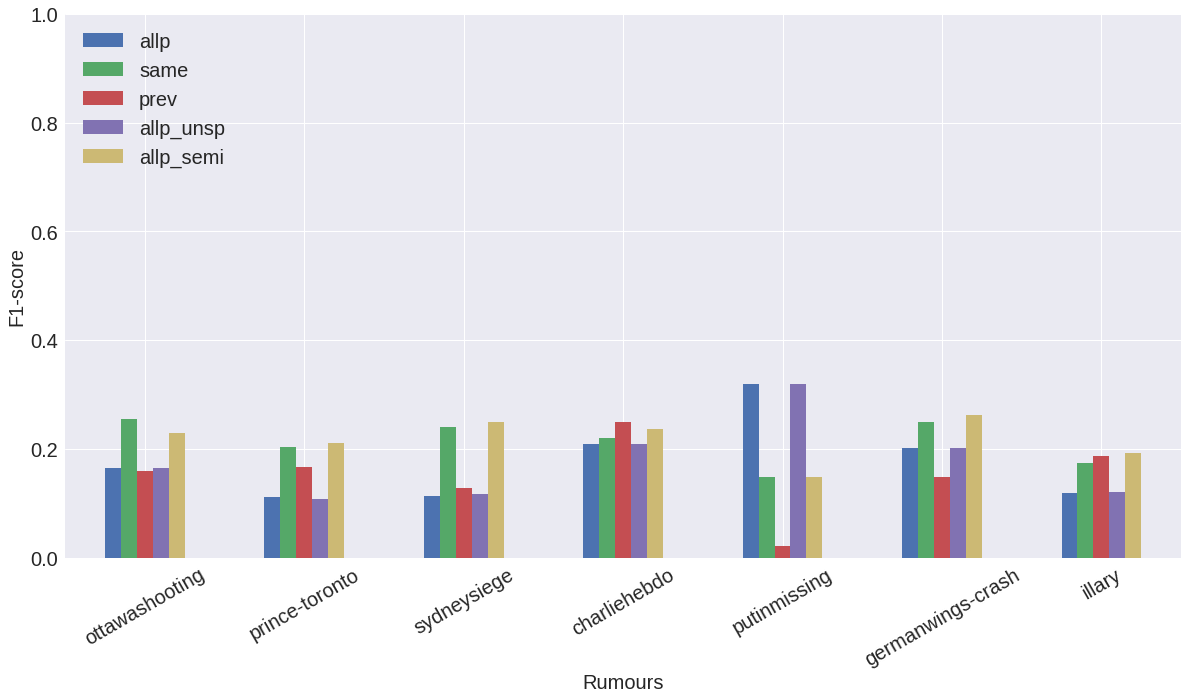

In [12]:
# Visualize performance in bar graph

# Initialize figure
fig, ax = plt.subplots(figsize=(20, 10))

# Bar plot
rum_results.plot.bar(ax=ax, x='rumours', y=['allp', 'same', 'prev', 'allp_unsp', 'allp_semi', 'prev_unsp', 'prev_semi'], rot=30, fontsize=fS, legend=True);

# Set axes properties
ax.set_ylim([0, 1]);
ax.legend(fontsize=fS, loc=2);
ax.set_xlabel('Rumours', fontsize=fS);
ax.set_ylabel('F1-score', fontsize=fS);

fig.savefig('resultsF1_rumEval19_subalign_dim' + str(subspace_dim) + '_nT' + str(nT) + '_nI' + str(nI) + '.png', bbox_inches='tight', padding=None)

In [11]:
rum_results

,rumours,allp,same,prev,allp_unsp,allp_semi,prev_unsp,prev_semi
0,ottawashooting,0.164580,0.254778,0.159370,0.164351,0.229561,0.159370,0.229446
1,prince-toronto,0.110843,0.203614,0.167470,0.107229,0.210843,0.167470,0.191566
2,sydneysiege,0.113062,0.239915,0.128552,0.117319,0.249708,0.128552,0.156906
3,charliehebdo,0.208151,0.220908,0.248697,0.208064,0.237076,0.248697,0.223196
4,putinmissing,0.319048,0.147619,0.021429,0.319048,0.147619,0.021429,0.095238
5,germanwings-crash,0.200873,0.248744,0.147502,0.202245,0.261417,0.147502,0.177724
6,illary,0.118479,0.173717,0.186994,0.120010,0.193257,0.186994,0.189425
